### Fine Tuning MobileNet for Sign Language Digits

#### Importing Necessary Import

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

##### Utility Functions 

In [2]:
# function to count parameters of a model

def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) 
                                    for v in model.trainable_weights])
    print(non_trainable_params,trainable_params)
    return {'non_trainable_params': non_trainable_params,'trainable_params': trainable_params}

In [3]:
# function to save models
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    PATH = os.getcwd()
    IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [4]:
# function for ploting trainging
def plot_training(history,name):
    hist = pd.DataFrame()
    hist["Train Loss"]=history.history['loss']
    hist["Validation Loss"]=history.history['val_loss']
    hist["Train Accuracy"]=history.history['accuracy']
    hist["Validation Accuracy"]=history.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(8,6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name) 
    plt.show()

In [5]:
# ploting the outputs using confusion matrix
def plot_confusion(y_test,y_predict,name):
	cm = confusion_matrix(y_test, y_predict)
	class_names=[0,1,2,3,4,5,6,7,8,9]
	fig, ax = plt.subplots(figsize=(6,6))
	tick_marks = np.arange(len(class_names))
	plt.xticks(tick_marks, class_names)
	plt.yticks(tick_marks, class_names)
	sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Purples" ,fmt='g')
	ax.xaxis.set_label_position("top")
	plt.tight_layout()
	plt.title('Confusion Matrix', y=1.1)
	plt.ylabel('Actual label')
	plt.xlabel('Predicted label')
	save_fig(name)
	plt.show()
	return

#### Dataset Preperation

In [6]:
# data preperation creating train test and valid dir
import shutil

# make sure are pointing to the dataset dir
os.chdir('../')
path = os.getcwd() + '/dataset' 
def data_preparation(path):
    os.chdir(path)
    if os.path.isdir('train/0/') is False:
        os.mkdir('train')
        os.mkdir('valid')
        os.mkdir('test')

        for i in range(0,10):
            shutil.move(f'{i}', 'train')
            os.mkdir(f'valid/{i}')
            os.mkdir(f'test/{i}')
        
            valid_samples = random.sample(os.listdir(f'train/{i}'),70)
            for j in valid_samples:
                shutil.move(f'train/{i}/{j}',f'valid/{i}')

            test_samples = random.sample(os.listdir(f'train/{i}'),15)
            for k in test_samples:
                shutil.move(f'train/{i}/{k}',f'test/{i}')
    return

data_preparation(path)

#### Ploting Images from Training Data

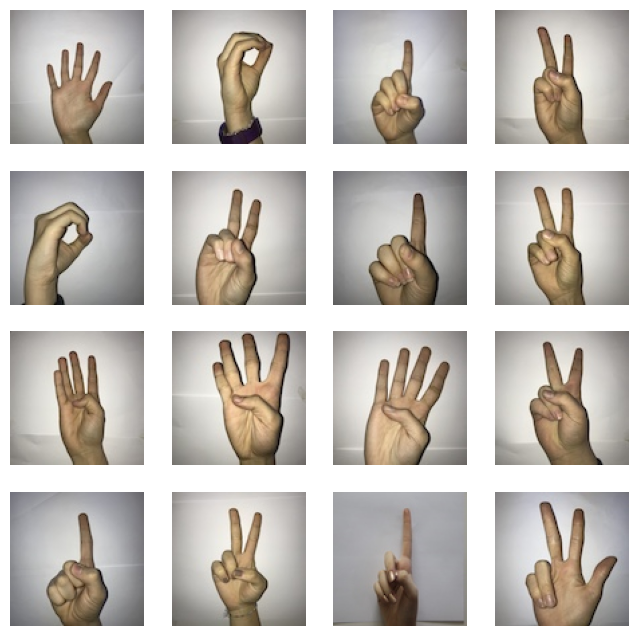

In [7]:
# ploting images from train dir

def plot_images(PATH):
  images = []
  for folder in os.listdir(PATH):
    for image in os.listdir(PATH + '/' + folder):
      images.append(os.path.join(PATH, folder, image))

  plt.figure(1, figsize=(8, 8))

  for i in range(16):
    i += 1
    random_img = random.choice(images)
    imgs = plt.imread(random_img)
    plt.subplot(4, 4,i)
    plt.axis('off')
    plt.imshow(imgs)
  plt.show()

# make sure you are pointing to train dir
PATH = os.getcwd() + '/train'
plot_images(PATH)

In [8]:
# function to create test, train and valid batches
from keras.preprocessing.image import ImageDataGenerator

def create_batches(path):


    train_path = path + '/train' 
    test_path = path + '/test' 
    valid_path = path + '/valid' 


    #  Create a data augmentor
    data_augmentor = ImageDataGenerator(
                                samplewise_center=True, 
                                rescale=1./255, 
                                shear_range=0.2,
                                zoom_range = 0.2,
                                samplewise_std_normalization=True,
                                validation_split=0.2) 

    # hyperpaameters
    n_batch = 32
    target_size = (224,224)

    # Create datasets
    train_batches = data_augmentor.flow_from_directory(
                                            directory=train_path,
                                            target_size=target_size,
                                            batch_size= n_batch,)
    
    valid_batches = data_augmentor.flow_from_directory(
                                            directory=valid_path,
                                            target_size=target_size,
                                            batch_size=n_batch)
    
    test_batches = data_augmentor.flow_from_directory(
                                            directory=test_path,
                                            target_size=target_size,
                                            batch_size= 10,
                                            shuffle=False)
   
    
    return (train_batches,test_batches,valid_batches)

# make sure you are pointing to the dataset dir
PATH = os.getcwd()
train_batches,test_batches,valid_batches = create_batches(PATH)

Found 1212 images belonging to 10 classes.
Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


#### Building Model

In [9]:
# modifing mobileNet for digit classification
from keras.layers import Dense,Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten
from keras.models import Sequential

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model
   

model = create_model()

#### Training the Model

In [10]:
# training the model 

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import RMSprop

def model_fit(model,train_batches, valid_batches,epoches =30, optimizer=RMSprop(learning_rate=1e-4)):

    callback = [ReduceLROnPlateau(monitor = 'val_loss', patience = 10, factor=0.25, verbose=1),
                ModelCheckpoint("models/conv_net.h5",save_best_only=True)]

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    history = model.fit(x=train_batches,
            validation_data=valid_batches,
            epochs=epoches,
            verbose=2,
            callbacks=callback)

    if os.path.isfile('models/conv_net.h5') is False:
        model.save('models/conv_net.h5')
    return (model,history)

os.chdir('../')
model, history = model_fit(model,train_batches,valid_batches)

Epoch 1/30
38/38 - 60s - loss: 2.4884 - accuracy: 0.2772 - val_loss: 2.2241 - val_accuracy: 0.2514 - lr: 1.0000e-04 - 60s/epoch - 2s/step
Epoch 2/30
38/38 - 57s - loss: 1.6335 - accuracy: 0.4719 - val_loss: 2.3135 - val_accuracy: 0.1086 - lr: 1.0000e-04 - 57s/epoch - 2s/step
Epoch 3/30
38/38 - 53s - loss: 1.2184 - accuracy: 0.5899 - val_loss: 2.5148 - val_accuracy: 0.1000 - lr: 1.0000e-04 - 53s/epoch - 1s/step
Epoch 4/30
38/38 - 51s - loss: 1.0659 - accuracy: 0.6518 - val_loss: 2.9002 - val_accuracy: 0.1000 - lr: 1.0000e-04 - 51s/epoch - 1s/step
Epoch 5/30
38/38 - 52s - loss: 0.8840 - accuracy: 0.7013 - val_loss: 2.9997 - val_accuracy: 0.1043 - lr: 1.0000e-04 - 52s/epoch - 1s/step
Epoch 6/30
38/38 - 56s - loss: 0.8179 - accuracy: 0.7327 - val_loss: 2.9268 - val_accuracy: 0.1114 - lr: 1.0000e-04 - 56s/epoch - 1s/step
Epoch 7/30
38/38 - 54s - loss: 0.7569 - accuracy: 0.7483 - val_loss: 2.9228 - val_accuracy: 0.1300 - lr: 1.0000e-04 - 54s/epoch - 1s/step
Epoch 8/30
38/38 - 58s - loss: 0.6

Saving figure conv_train 


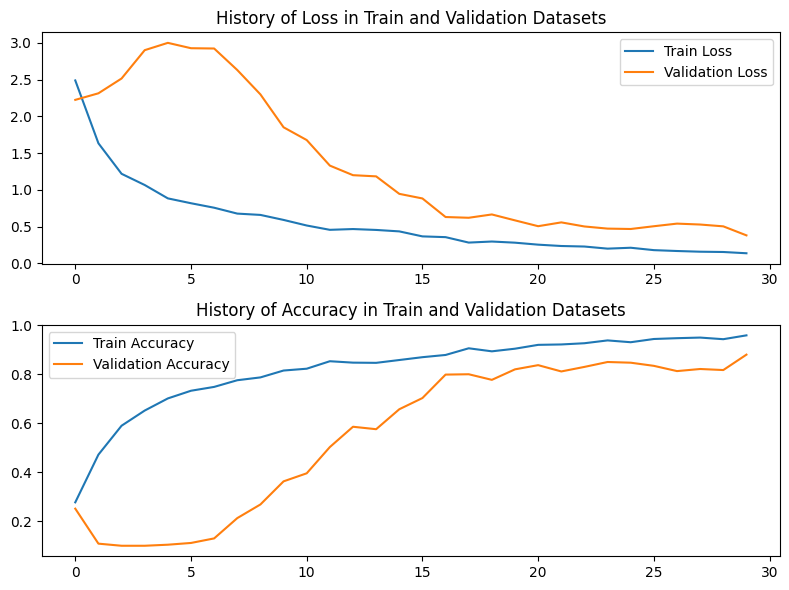

In [11]:
plot_training(history,'conv_train ')

In [13]:
os.chdir('sign_lang_digits')

Saving figure conv_cm


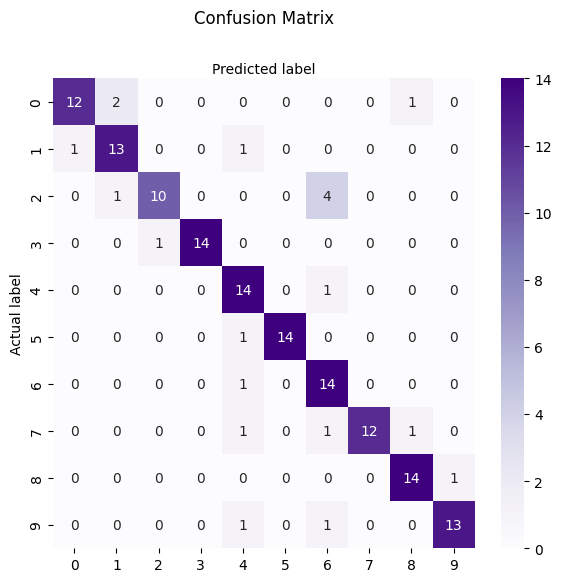

In [14]:
test_labels = test_batches.classes

predictions = model.predict(x=test_batches, verbose=0)

# os.chdir('../')
y_pred=predictions.argmax(axis=1)
plot_confusion(test_labels,y_pred,'conv_cm')

#### Save Model

In [15]:
# saving model
os.chdir('models')
model.save("conv_net.h5")